In [23]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Markdown, display
from networks import *
from model import model, configurator, configurator_classificators, configurator_backward, posterior_configurator, constrain_parameters, constrained_parameter_names, latex_model
from cmdstanpy import CmdStanModel
from bayesflow.trainers import Trainer
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from logging import getLogger

import bayesflow.diagnostics as diagnostics

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

In [24]:
stan_model = CmdStanModel(stan_file="stan-model.stan")

In [25]:
forward = Trainer(
    amortizer=AmortizedMixture(
        inference_net=Sequential(
            [
                LSTM(32, return_sequences=True),
                Classifier(n_classes=2, n_units=[32, 16, 8, 4, 2])
            ]
        ),
        local_summary_net=LSTM(units=128, return_sequences=True),
        ), 
    generative_model=model, 
    configurator=configurator_classificators, 
    checkpoint_path="checkpoints/forward"
)

INFO:root:Loaded loss history from checkpoints/forward/history_48.pkl.
INFO:root:Networks loaded from checkpoints/forward/ckpt-48
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [26]:
backward = Trainer(
    amortizer=AmortizedMixture(
        inference_net=Sequential(
            [
                LSTM(32, return_sequences=True),
                Classifier(n_classes=2, n_units=[32, 16, 8, 4, 2])
            ]
        ),
        local_summary_net=LSTM(units=128, return_sequences=True),
        ), 
    generative_model=model, 
    configurator=configurator_backward, 
    checkpoint_path="checkpoints/backward"
)

INFO:root:Loaded loss history from checkpoints/backward/history_33.pkl.
INFO:root:Networks loaded from checkpoints/backward/ckpt-33
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [27]:
smoothing = AmortizedSmoothing(forward.amortizer, backward.amortizer)

In [28]:
posterior = Trainer(
    amortizer=AmortizedPosterior(
    inference_net=InvertibleNetwork(num_params=4, num_coupling_layers=10, coupling_design="spline"),
    summary_net=SequenceNetwork(summary_dim=12, num_conv_layers=4, bidirectional=True),
    summary_loss_fun = "MMD"),
    generative_model=model,
    configurator=posterior_configurator,
    checkpoint_path="checkpoints/posterior"
)

INFO:root:Loaded loss history from checkpoints/posterior/history_100.pkl.
INFO:root:Networks loaded from checkpoints/posterior/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


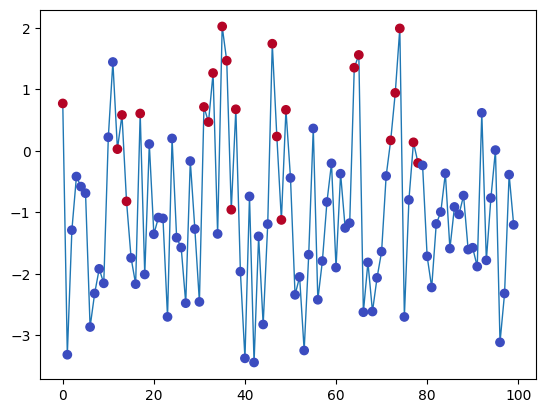

In [29]:
true_params_unconstrained = np.array([[2.75, 0.25, -1.5, 0.8]])
true_params = constrain_parameters(true_params_unconstrained)

df = model.simulator(true_params_unconstrained)
df['prior_draws'] = true_params_unconstrained

# df['sim_data'][0,:,0] = np.array([-1.5 + 3 * np.exp(- 0.003 * (t-50)**2) for t in range(100)])
# df['sim_data'][0,:,1] = np.float32(df['sim_data'][0,:,0] < 0.0)
# df['sim_data'][0,:,0] = df['sim_data'][0,:,0] + np.random.normal(loc=0, scale=0.01, size=100)

df_classification = configurator_classificators(df)
df_backward = configurator_backward(df)
df_posterior = posterior_configurator(df)

observables = df_classification['summary_conditions'][0,...,0]
latents = df_classification['latents'][0,...,1]

stan_df = {
    "n_obs": 100,
    "y": observables,
    "alpha": [[2, 2], [2, 2]]
}


plt.plot(observables, linewidth=1, zorder=-1)
f=plt.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')

In [30]:
df['sim_data'].shape

(1, 100, 2)

In [31]:
stan_fit = stan_model.sample(stan_df, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpetxa21lc/stan-modelfr68edtc/stan-model-20240702155845_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpetxa21lc/stan-modelfr68edtc/stan-model-20240702155845_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpetxa21lc/stan-modelfr68edtc/stan-model-20240702155845_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpetxa21lc/stan-modelfr68edtc/stan-model-20240702155845_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [32]:
stan_posterior = stan_fit.draws_pd(vars = ["transition_matrix", "mu"])
stan_posterior = np.array(stan_posterior)
stan_posterior = stan_posterior[:, (0, 3, 4, 5)]

In [33]:
bf_posterior_unconstrained = posterior.amortizer.sample(df_posterior, n_samples=4000)
bf_posterior = constrain_parameters(bf_posterior_unconstrained)

df_classification["direct_conditions"] = tf.expand_dims(bf_posterior_unconstrained, axis=0)
df_backward["direct_conditions"] = tf.expand_dims(bf_posterior_unconstrained, axis=0)

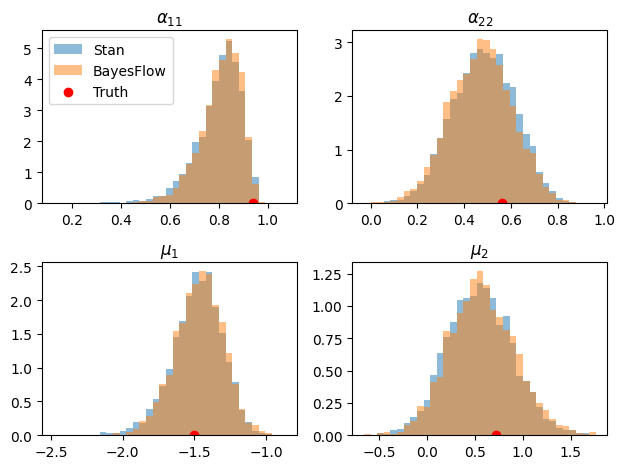

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()

bins = [
    np.linspace(np.min(stan_posterior[:,i])-0.1, np.max(stan_posterior[:,i])+0.1, 36) for i in range(4)
]
for i, par in enumerate(constrained_parameter_names):
    axs[i].hist(stan_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="Stan")
    axs[i].hist(bf_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="BayesFlow")
    axs[i].scatter(true_params[0,i], 0, color="red", label="Truth")
    axs[i].set_title(par)

axs[0].legend()
fig.tight_layout()

In [35]:
def loss_fun(latents, probs):
    lf = CategoricalCrossentropy()
    latents = np.tile(latents[0], (probs.shape[0], 1, 1))
    return lf(latents, probs)
losses = dict()

In [36]:
stan_filtering = stan_fit.stan_variables()["filtering"]
stan_smoothing = stan_fit.stan_variables()["smoothing"]
stan_backward  = stan_fit.stan_variables()["backward_filtering"]

losses['stan_filtering'] = loss_fun(df_classification["latents"], stan_filtering)#loss_fun(np.tile(df_classification["latents"][0], (stan_filtering.shape[0], 1, 1)), stan_filtering)
losses['stan_smoothing'] = loss_fun(df_classification["latents"], stan_smoothing)#loss_fun(np.tile(df_classification["latents"][0], (stan_filtering.shape[0], 1, 1)), stan_smoothing)
losses['stan_backward']  = loss_fun(df_classification["latents"], stan_backward)

stan_filtering = stan_filtering[...,1]
stan_smoothing = stan_smoothing[...,1]
stan_backward  = stan_backward[...,1]

In [37]:
bf_forward = forward.amortizer.sample(df_classification)

In [38]:
bf_backward = backward.amortizer.sample(df_backward)
bf_backward = tf.reverse(bf_backward, axis=[2])

In [39]:
bf_smoothing = smoothing.sample(df_classification, df_backward)

In [40]:
losses['bf_forward'] = loss_fun(df_classification["latents"], bf_forward[0])
losses['bf_backward'] = loss_fun(df_classification["latents"], bf_backward[0])
losses['bf_smoothing'] = loss_fun(df_classification["latents"], bf_smoothing[0])

In [41]:
bf_forward=bf_forward[0,...,1]
bf_backward=bf_backward[0,...,1]
bf_smoothing=bf_smoothing[0,...,1]

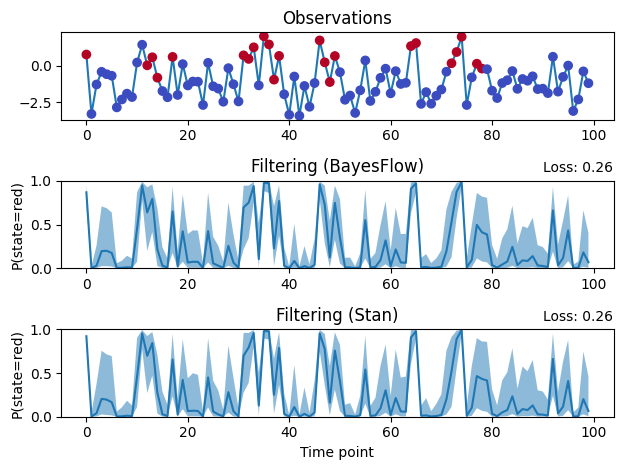

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(range(len(observables)), observables, zorder=-1)
ax1.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_forward, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_forward, q=0.01, axis=0),
    np.quantile(bf_forward, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf_forward"]))
ax2.set_title("Filtering (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])


ax3.plot(range(len(observables)), np.median(stan_filtering, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_filtering, q=0.01, axis=0),
    np.quantile(stan_filtering, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan_filtering"]))
ax3.set_title("Filtering (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

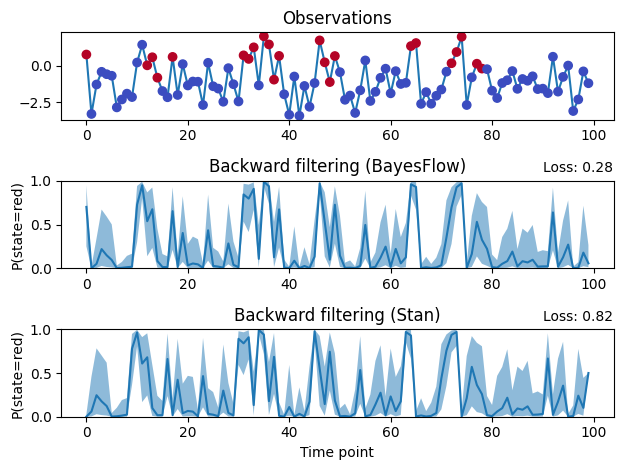

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(range(len(observables)), observables, zorder=-1)
ax1.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_backward, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_backward, q=0.01, axis=0),
    np.quantile(bf_backward, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf_backward"]))
ax2.set_title("Backward filtering (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])

ax3.plot(range(len(observables)), np.median(stan_backward, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_backward, q=0.01, axis=0),
    np.quantile(stan_backward, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan_backward"]))
ax3.set_title("Backward filtering (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

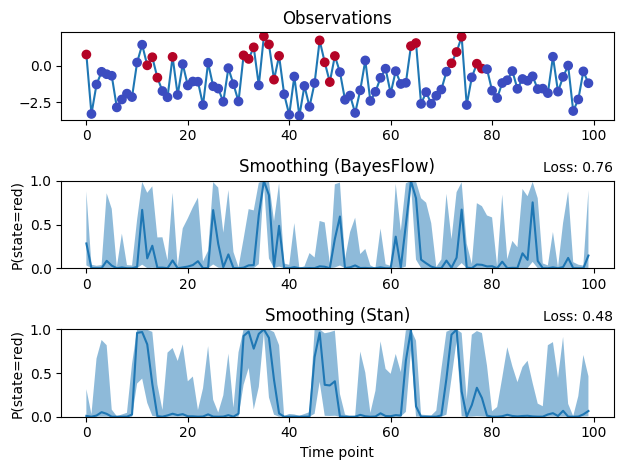

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(range(len(observables)), observables, zorder=-1)
ax1.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_smoothing, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_smoothing, q=0.01, axis=0),
    np.quantile(bf_smoothing, q=0.99, axis=0),
    alpha=0.5
)
ax2.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["bf_smoothing"]))
ax2.set_title("Smoothing (BayesFlow)")
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])

ax3.plot(range(len(observables)), np.median(stan_smoothing, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_smoothing, q=0.01, axis=0),
    np.quantile(stan_smoothing, q=0.99, axis=0),
    alpha=0.5
)
ax3.text(len(observables)-10, 1.1, "Loss: {0:.2f}".format(losses["stan_smoothing"]))
ax3.set_title("Smoothing (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()